# Imports

In [1]:
import torch
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F

import matplotlib.pyplot as plt
from IPython.display import IFrame

%matplotlib inline

import numpy as np
# For generated GIF
import imageio

torch.manual_seed(42); # Дабы случайные результаты повторялись

# Generate DS

In [2]:
# Generated random equidisributed subsequence 
# Sort our subsequence
# [1] - indexes
# Make more main view
x = torch.unsqueeze(torch.sort(torch.rand(100))[0], dim=1)
x = x*2 - 1
x_t = torch.unsqueeze(torch.sort(torch.rand(100))[0], dim=1)
x_t = x_t*2 - 1

y_true = torch.pow(x, 2)
y_t = torch.pow(x_t, 2)
y = torch.pow(x, 2) + (torch.rand(x.size()) - 0.5) / 3

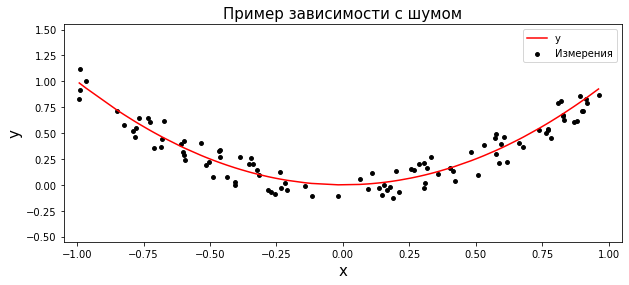

In [3]:
x, y = Variable(x), Variable(y)
plt.figure(figsize=(10, 4))
plt.scatter(x.data.numpy(), y.data.numpy(), color='black', label='Измерения', s=15)

plt.plot(x.data.numpy(), y_true, color='red', label='y')
plt.title('Пример зависимости с шумом', fontdict={'size': 15})
plt.xlabel('x', fontdict={'size': 15})
plt.ylabel('y', fontdict={'size': 15})
plt.xlim(-1.05, 1.05)
plt.ylim(-.55, 1.55)
plt.legend()
plt.show()

# Create a Perseptrone

In [4]:
class Net(torch.nn.Module):
    def __init__(self,  
                 n_feature, 
                 n_hidden,
                 n_output, 
                 use_bias=False):
        super(Net, self).__init__()
        # self.output = torch.nn.Linear(n_feature, n_output, bias=use_bias)
        self.hidden = torch.nn.Linear(n_feature, n_hidden)
        self.predict = torch.nn.Linear(n_hidden, n_output)
    
    def forward(self, x):
        # x = self.output(x)
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

In [5]:
net = Net(n_feature=1, n_hidden=100, n_output=1)
loss_func = torch.nn.MSELoss()

In [6]:
BATCH_SIZE = 64
EPOCH = 40

torch_dataset = Data.TensorDataset(x, y)

loader = Data.DataLoader(
    dataset=torch_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
)

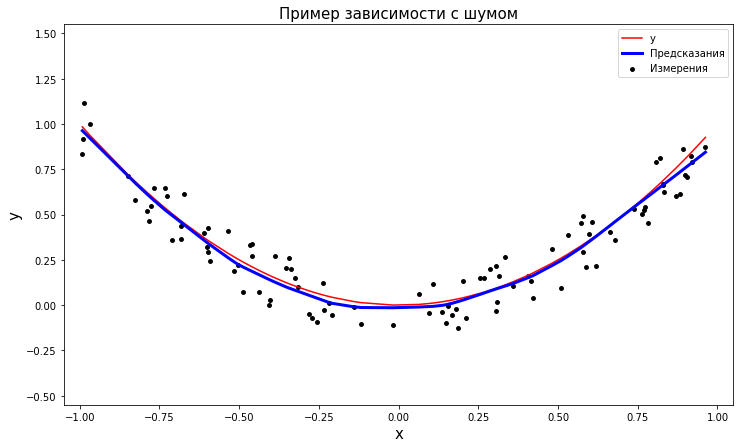

In [7]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

my_images = []
fig, ax = plt.subplots(figsize=(12, 7))

for epoch in range(EPOCH):
    for step, (batch_x, batch_y) in enumerate(loader):
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)
        
        prediction = net(b_x) # make a predict

        loss = loss_func(prediction, b_y) # calculate loss function
        
        prediction = net(x)
        
        loss = loss_func(y, prediction) # calculate loss function

        optimizer.zero_grad() # zeroing grads
        loss.backward() # Calculate misstake
        optimizer.step() # step to optimization

        plt.cla()
        ax.scatter(x.data.numpy(), y.data.numpy(), color='black', label='Измерения', s=15)
        plt.plot(x.data.numpy(), y_true, color='red', label='y')
        plt.plot(x.data.numpy(), prediction.data.numpy(), color='blue', lw=3, label='Предсказания')

        plt.title('Пример зависимости с шумом', fontdict={'size': 15})
        plt.xlabel('x', fontdict={'size': 15})
        plt.ylabel('y', fontdict={'size': 15})
        plt.xlim(-1.05, 1.05)
        plt.ylim(-.55, 1.55)
        plt.legend()
    
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

        my_images.append(image)

# To freeze our gif
for _ in range(10):
    my_images.append(image)

imageio.mimsave('./gif/non_linear.gif', my_images, fps=10)
IFrame(src='./gif/non_linear.gif', width=900, height=550)